In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import math
import numpy.random as random
from PIL import Image
from skimage.io import imread, imsave

from sklearn.model_selection import cross_validate, train_test_split
from keras.utils import np_utils
from helpers import *

import tensorflow as tf
import keras.models as models
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, LeakyReLU
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adamax, Adam, SGD
from keras.regularizers import l2

from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Using TensorFlow backend.


In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    y_true_am = K.argmax(y_true, axis=1)
    y_pred_am = K.argmax(y_pred, axis=1)
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives)
        return recall

    def precision(y_true, y_pred):
        
        
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives)
        return precision
    
    precision = precision(y_true_am, y_pred_am)
    recall = recall(y_true_am, y_pred_am)
    return 2*((precision*recall)/(precision+recall))

In [3]:
from sklearn.utils import class_weight
from keras.regularizers import l2

class CnnModel:
    
    def __init__(self, **args):
        pass
    def initialize_model(self, window=72, dropout=False):
        K.clear_session()
        #model 
        self.model = models.Sequential()
        self.model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(window,window,3)))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        if dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Conv2D(128, 3, padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        if dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Conv2D(512, 3, padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        if dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        if dropout:
            self.model.add(Dropout(0.5))
        self.model.add(Dense(2, activation='softmax'))
    
    def fit(self, imgs, gt_imgs, patch=16, window=72, augment=False, dropout = False,
            num_batches=128, steps_per_epoch=64, epochs=5, validation_steps=32, seed=42, verbose=1):
        self.initialize_model(window, dropout)
        self.window = window
        
        def random_crop(img, gt_img, patch=16, window=72, seed=1):
            padding = (window-patch)//2
            img = np.lib.pad(img, ((padding, padding), (padding, padding), (0,0)), 'reflect')
            gt_img = np.lib.pad(gt_img, ((padding, padding), (padding, padding), (0,0)), 'reflect')

            center = np.random.randint(window//2, img.shape[0] - window//2, 2)

            img_crop = img[center[0]-window//2:center[0]+window//2, center[1]-window//2:center[1]+window//2]
            gt_crop = gt_img[center[0]-patch//2:center[0]+patch//2, center[1]-patch//2:center[1]+patch//2]

            return img_crop, one_hot_gt(gt_crop)

        def generate_train(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
            while 1:
                batch_x = []
                batch_y = []
                for i in range(num_batches):
                    idx = random.choice(imgs.shape[0])
                    train_x, train_y = random_crop(imgs[idx], gt_imgs[idx], patch, window, seed)
                    if augment:
                        if random.choice(2):
                            img_crop = np.flipud(train_x)
                        if random.choice(2):
                            img_crop = np.fliplr(train_x)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(train_x, rot)

                    batch_x.append(train_x)
                    batch_y.append(train_y)
                yield(np.array(batch_x), np.array(batch_y))
        
        def generate_test(num_batches, imgs, gt_imgs, patch=16, window=72, augment=False, seed=1):
            imgs_cropped = []
            for img in imgs:
                imgs_cropped += crop_img(img, patch, window)
            gt_imgs_cropped = crop_and_one_hot(gt_imgs, patch)
            while 1:
                batch_x = []
                batch_y = []
                for i in range(num_batches):
                    idx = random.choice(len(imgs_cropped))
                    test_x = imgs_cropped[idx]
                    test_y = gt_imgs_cropped[idx]
                    if augment:
                        if random.choice(2):
                            img_crop = np.flipud(test_x)
                        if random.choice(2):
                            img_crop = np.fliplr(test_x)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(test_x, rot)
                    batch_x.append(test_x)
                    batch_y.append(test_y)
                yield(np.array(batch_x), np.array(batch_y))
                
#         X_train, X_test, y_train, y_test = train_test_split(imgs, gt_imgs, test_size=0.1, random_state=seed)
#         train_generator = generate_train(num_batches, X_train, y_train, patch=patch, window=window,
#                                          augment=augment, seed=seed)
        train_generator = generate_train(num_batches, imgs, gt_imgs, patch=patch, window=window,
                                         augment=augment, seed=seed)
#         X_test = crop_imgs(X_test, patch, window)
#         y_test = crop_and_one_hot(y_test, patch)
        cw = class_weight.compute_class_weight('balanced', [0,1], np.argmax(crop_and_one_hot(gt_imgs, 16), axis=1))
        cw = dict(enumerate(cw))
        def softmax_categorical_crossentropy(y_true, y_pred):
            return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

        self.model.compile(loss=softmax_categorical_crossentropy, optimizer='adam', metrics=['accuracy', f1])
        self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                                 class_weight=cw, verbose=verbose)
    
    def predict(self, imgs, batch_size=128):
        cropped_imgs = crop_imgs(imgs, 16, self.window)
        predictions = self.model.predict(cropped_imgs, batch_size)
        return np.argmax(predictions, axis=1)
    
    def get_params(self, deep=True):
        return {'x': None}
    
    def set_params(self, **params):
        pass

In [ ]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
cnnModel = CnnModel()

for window in (16, 72):
    for augment in (False, True):
        for dropout in (False, True):
            fit_params = {'window': window, 'augment': augment, 'dropout': dropout,
                          'num_batches' : 128, 'steps_per_epoch': 64, 'epochs' : 10, 'verbose': 0}
            scoring_params = {'batch_size': 128}

            cv_score = k_fold_model(cnnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
            print("Cnn model with window %d, augment %r, dropout %r"%(window, augment, dropout))
            print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
            print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

Cnn model with window 16, augment False, dropout False
Accuracy: 0.736 ± 0.036
F1 score 0.315 ± 0.182


/home/raph/.conda/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cnn model with window 16, augment False, dropout True
Accuracy: 0.649 ± 0.075
F1 score 0.357 ± 0.215
Cnn model with window 16, augment True, dropout False
Accuracy: 0.732 ± 0.022
F1 score 0.412 ± 0.234
Cnn model with window 16, augment True, dropout True
Accuracy: 0.694 ± 0.026
F1 score 0.492 ± 0.103
Cnn model with window 72, augment False, dropout False
Accuracy: 0.698 ± 0.052
F1 score 0.427 ± 0.250
Cnn model with window 72, augment False, dropout True
Accuracy: 0.735 ± 0.028
F1 score 0.024 ± 0.031
Cnn model with window 72, augment True, dropout False
Accuracy: 0.674 ± 0.110
F1 score 0.124 ± 0.211


In [5]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
cnnModel = CnnModel()

for window in [72]:
    for augment in [True]:
        for dropout in [True]:
            fit_params = {'window': window, 'augment': augment, 'dropout': dropout,
                          'num_batches' : 128, 'steps_per_epoch': 64, 'epochs' : 10, 'verbose': 0}
            scoring_params = {'batch_size': 128}

            cv_score = k_fold_model(cnnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
            print("Cnn model with window %d, augment %r, dropout %r"%(window, augment, dropout))
            print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
            print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

Cnn model with window 72, augment True, dropout True
Accuracy: 0.716 ± 0.038
F1 score 0.372 ± 0.223


In [ ]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
cnnModel = CnnModel()

window = 16
augment = False
dropout = False

fit_params = {'window': window, 'augment': augment, 'dropout': dropout,
              'num_batches' : 128, 'steps_per_epoch': 64, 'epochs' : 10, 'verbose': 1}
scoring_params = {'batch_size': 128}

cv_score = k_fold_model(cnnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

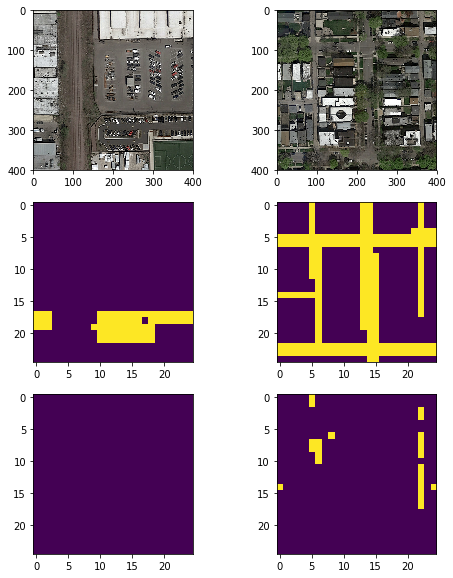

In [44]:
plt.figure(figsize=(8, 10))
plt.subplot(321)
plt.imshow(imgs[0])
plt.subplot(323)
plt.imshow(np.argmax(crop_and_one_hot(gt_imgs[:1]), axis=1).reshape(25,25))
plt.subplot(325)
plt.imshow(np.argmax(cnnModel.predict(np.array([crop.tolist() for crop in crop_img(imgs[0], 16, 72)])), axis=1).reshape(25,25))
plt.subplot(322)
plt.imshow(imgs[1])
plt.subplot(324)
plt.imshow(np.argmax(crop_and_one_hot(gt_imgs[1:2]), axis=1).reshape(25,25))
plt.subplot(326)
plt.imshow(np.argmax(cnnModel.predict(np.array([crop.tolist() for crop in crop_img(imgs[1], 16, 72)])), axis=1).reshape(25,25))